✅ Dataset loaded with 42 rows

                    min     max
BFC (%)             0.0     1.0
Temperature (°C)  200.0  1000.0
Duration (min)     20.0    60.0

🎯 Target total runs: ~20
→ Factorial runs: 8
→ Axial runs: 6
→ Center points (factorial region): 3
→ Center points (axial region): 3

=== Generated Face-Centered CCD Matrix (α = 1) ===
    A_coded  B_coded  C_coded  BFC (%)  Temperature (°C)  Duration (min)  Run
0      -1.0     -1.0     -1.0      0.0             200.0            20.0    1
1       1.0     -1.0     -1.0      1.0             200.0            20.0    2
2      -1.0      1.0     -1.0      0.0            1000.0            20.0    3
3       1.0      1.0     -1.0      1.0            1000.0            20.0    4
4      -1.0     -1.0      1.0      0.0             200.0            60.0    5
5       1.0     -1.0      1.0      1.0             200.0            60.0    6
6      -1.0      1.0      1.0      0.0            1000.0            60.0    7
7       1.0      1.0      1.0  

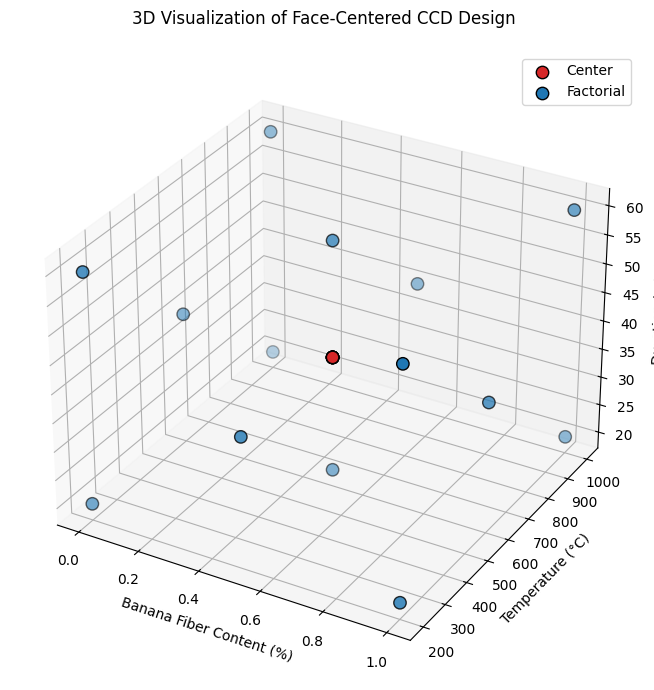


📊 3D CCD visualization saved as: CCD_3D_Visualization.png


In [1]:
# ===========================================================
# Auto Face-Centered Central Composite Design (CCD)
# with 3D Visualization and ~20 total runs
# ===========================================================
# Requirements:
# pip install pandas numpy pyDOE2 matplotlib openpyxl

import pandas as pd
import numpy as np
from pyDOE2 import ccdesign
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# -----------------------------
# USER CONFIGURATION
# -----------------------------
DATA_PATH = "dataset4.xlsx"   # <-- replace with your dataset
SHEET_NAME = 0
OUT_DIR = "ccd_design_outputs_facecentered"
os.makedirs(OUT_DIR, exist_ok=True)

# -----------------------------
# 1. Load Dataset and Extract Ranges
# -----------------------------
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
df.columns = df.columns.str.strip()

factors = ['BFC (%)', 'Temperature (°C)', 'Duration (min)']
for f in factors:
    df[f] = pd.to_numeric(df[f], errors='coerce')

print(f"✅ Dataset loaded with {len(df)} rows\n")
print(df[factors].describe().T[['min', 'max']])

ranges = {f: (df[f].min(), df[f].max()) for f in factors}

# -----------------------------
# 2. Determine center point counts for ~20 total runs
# -----------------------------
k = 3  # number of factors
factorial_runs = 2 ** k
axial_runs = 2 * k
target_total = 20
remaining = target_total - (factorial_runs + axial_runs)
center_factorial = max(1, remaining // 2)
center_axial = max(1, remaining - center_factorial)

print(f"\n🎯 Target total runs: ~{target_total}")
print(f"→ Factorial runs: {factorial_runs}")
print(f"→ Axial runs: {axial_runs}")
print(f"→ Center points (factorial region): {center_factorial}")
print(f"→ Center points (axial region): {center_axial}")

# -----------------------------
# 3. Generate Face-Centered CCD (α = 1)
# -----------------------------
ccd_face = ccdesign(k, center=(center_factorial, center_axial), face='ccf')
ccd_df = pd.DataFrame(ccd_face, columns=['A_coded', 'B_coded', 'C_coded'])

# -----------------------------
# 4. Map coded (-1, 0, +1) to actual dataset-based ranges
# -----------------------------
for i, f in enumerate(factors):
    low, high = ranges[f]
    center = (low + high) / 2
    half_range = (high - low) / 2
    coded = ccd_df.iloc[:, i]
    ccd_df[f] = center + coded * half_range

ccd_df['Run'] = np.arange(1, len(ccd_df) + 1)

# -----------------------------
# 5. Save and Display Results
# -----------------------------
print("\n=== Generated Face-Centered CCD Matrix (α = 1) ===")
print(ccd_df.round(3))
out_path = f"{OUT_DIR}/Face_Centered_CCD_Matrix_20runs.xlsx"
ccd_df.to_excel(out_path, index=False)
print(f"\n💾 CCD matrix saved to: {out_path}")

# -----------------------------
# 6. Design Breakdown Summary
# -----------------------------
total_runs = len(ccd_df)
factorial_runs = 2 ** k
axial_runs = 2 * k
center_runs = total_runs - (factorial_runs + axial_runs)

print("\n=== CCD Design Breakdown ===")
print(f"→ Factorial points : {factorial_runs}")
print(f"→ Axial (star) points : {axial_runs}")
print(f"→ Center points : {center_runs}")
print(f"→ Total runs : {total_runs}")

summary = pd.DataFrame({
    'Factor': factors,
    'Data Min': [ranges[f][0] for f in factors],
    'Data Max': [ranges[f][1] for f in factors],
    'CCD Min': [ccd_df[f].min() for f in factors],
    'CCD Max': [ccd_df[f].max() for f in factors]
})
summary_path = f"{OUT_DIR}/CCD_Range_Summary.xlsx"
summary.to_excel(summary_path, index=False)

print("\n=== CCD Range Summary ===")
print(summary.round(3))
print(f"\n📘 Range summary saved to: {summary_path}")

# -----------------------------
# 7. 3D Scatter Visualization
# -----------------------------
def identify_point_type(row):
    if any(abs(val) == 1 for val in [row['A_coded'], row['B_coded'], row['C_coded']]) and all(abs(val) <= 1 for val in [row['A_coded'], row['B_coded'], row['C_coded']]):
        return 'Factorial'
    elif any(abs(val) == 1 for val in [row['A_coded'], row['B_coded'], row['C_coded']]) and any(val == 0 for val in [row['A_coded'], row['B_coded'], row['C_coded']]):
        return 'Axial'
    elif all(val == 0 for val in [row['A_coded'], row['B_coded'], row['C_coded']]):
        return 'Center'
    else:
        return 'Other'

ccd_df['PointType'] = ccd_df.apply(identify_point_type, axis=1)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

colors = {'Factorial':'tab:blue', 'Axial':'tab:orange', 'Center':'tab:red'}
for ptype, group in ccd_df.groupby('PointType'):
    ax.scatter(group['BFC (%)'], group['Temperature (°C)'], group['Duration (min)'],
               color=colors.get(ptype, 'gray'), s=80, label=ptype, edgecolor='k')

ax.set_xlabel('Banana Fiber Content (%)')
ax.set_ylabel('Temperature (°C)')
ax.set_zlabel('Duration (min)')
ax.set_title('3D Visualization of Face-Centered CCD Design', pad=20)
ax.legend()
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/CCD_3D_Visualization.png", dpi=300)
plt.show()

print("\n📊 3D CCD visualization saved as: CCD_3D_Visualization.png")


In [4]:
# ===========================================================
# FINAL RSM PIPELINE: Face-Centered CCD + RSM + Visualization
# ===========================================================
# Requirements:
# pip install pandas numpy pyDOE2 statsmodels seaborn matplotlib sympy scikit-learn openpyxl

import pandas as pd
import numpy as np
from pyDOE2 import ccdesign
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import sympy as sp
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

# ===========================================================
# 1. CONFIGURATION
# ===========================================================
DATA_PATH = "dataset4.xlsx"
SHEET_NAME = 0
OUT_DIR = "ccd_full_analysis"
os.makedirs(OUT_DIR, exist_ok=True)

# ===========================================================
# 2. LOAD DATA
# ===========================================================
df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
df.columns = df.columns.str.strip()

required_cols = ['Strength (MPa)', 'BFC (%)', 'Temperature (°C)', 'Duration (min)', 'Batch type']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

for c in ['Strength (MPa)', 'BFC (%)', 'Temperature (°C)', 'Duration (min)']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

print(f"\n✅ Dataset loaded with {len(df)} rows")
print(df[['BFC (%)','Temperature (°C)','Duration (min)']].describe().T[['min','max']])

# ===========================================================
# 3. FACE-CENTERED CCD (~20 RUNS)
# ===========================================================
factors = ['BFC (%)', 'Temperature (°C)', 'Duration (min)']
ranges = {f: (df[f].min(), df[f].max()) for f in factors}

k = 3
factorial_runs = 2 ** k
axial_runs = 2 * k
target_total = 20
remaining = target_total - (factorial_runs + axial_runs)
center_factorial = max(1, remaining // 2)
center_axial = max(1, remaining - center_factorial)

ccd_face = ccdesign(k, center=(center_factorial, center_axial), face='ccf')
ccd_df = pd.DataFrame(ccd_face, columns=['A_coded','B_coded','C_coded'])

for i, f in enumerate(factors):
    low, high = ranges[f]
    center = (low + high)/2
    half = (high - low)/2
    ccd_df[f] = center + half * ccd_df.iloc[:,i]

ccd_df['Run'] = np.arange(1, len(ccd_df)+1)
ccd_df.to_excel(f"{OUT_DIR}/FaceCentered_CCD_20runs.xlsx", index=False)

print("\n=== Generated Face-Centered CCD Matrix (α=1) ===")
print(ccd_df.round(3))

# ===========================================================
# 4. DESCRIPTIVE STATISTICS
# ===========================================================
desc = df.describe()
desc.loc['CV%'] = (desc.loc['std']/desc.loc['mean'])*100
desc.to_excel(f"{OUT_DIR}/Descriptive_Stats.xlsx")

print("\n=== Descriptive Statistics ===")
print(desc.round(3))

# ===========================================================
# 5. SPLIT BY TEST TYPE
# ===========================================================
df['TestType'] = df['Batch type'].apply(lambda x: 'Compressive' if 'COMPRESS' in str(x).upper()
                                        else ('Flexural' if 'FLEX' in str(x).upper() else 'Other'))
comp_df = df[df['TestType']=='Compressive']
flex_df = df[df['TestType']=='Flexural']

print(f"\nCompressive rows: {len(comp_df)} | Flexural rows: {len(flex_df)}")

# ===========================================================
# 6. RSM MODEL FUNCTIONS
# ===========================================================
def build_X(df_in, factors):
    X = pd.DataFrame({'const': np.ones(len(df_in))}, index=df_in.index)
    for f in factors:
        X[f] = df_in[f]
    for i in range(len(factors)):
        for j in range(i+1, len(factors)):
            X[f"{factors[i]}*{factors[j]}"] = df_in[factors[i]] * df_in[factors[j]]
    for f in factors:
        X[f"{f}^2"] = df_in[f]**2
    return X

def fit_rsm_clean(df_in, response='Strength (MPa)', label='Compressive'):
    print(f"\n--- Fitting RSM for {label} ---")
    df_clean = df_in.replace([np.inf, -np.inf], np.nan).dropna(subset=[response] + factors)
    if len(df_clean) < 10:
        print(f"⚠️ Not enough valid data for {label}.")
        return None, None, None

    X = build_X(df_clean, factors)
    y = df_clean[response]
    model = sm.OLS(y, X).fit()
    print(model.summary())

    # Residual Diagnostics
    resid, fitted = model.resid, model.fittedvalues
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=fitted, y=resid)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{label} - Residuals vs Fitted")
    plt.xlabel("Fitted")
    plt.ylabel("Residuals")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label}_Residuals_vs_Fitted.png", dpi=300)
    plt.close()

    sm.qqplot(resid, line='45', fit=True)
    plt.title(f"{label} - QQ Plot")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label}_QQPlot.png", dpi=300)
    plt.close()

    # VIF
    vif = pd.DataFrame({
        'Term': X.drop(columns='const').columns,
        'VIF': [variance_inflation_factor(X.drop(columns='const').values, i)
                for i in range(X.drop(columns='const').shape[1])]
    })
    print("\n--- VIF ---")
    print(vif.round(3))

    # Metrics
    y_pred = model.fittedvalues
    r2 = r2_score(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)

    return model, df_clean, {'R2': r2, 'RMSE': rmse, 'MAE': mae}

comp_model, comp_clean, comp_metrics = fit_rsm_clean(comp_df, label='Compressive')
flex_model, flex_clean, flex_metrics = fit_rsm_clean(flex_df, label='Flexural')

# ===========================================================
# 7. SYMBOLIC EQUATION EXPORT
# ===========================================================
def export_rsm_equation(model, label):
    if model is None: return ""
    coeffs = model.params.to_dict()
    A,B,C = sp.symbols('A B C')
    eq = coeffs['const']
    for k,v in coeffs.items():
        if k=='const': continue
        if 'BFC' in k and '*' not in k and '^' not in k:
            eq += v*A
        elif 'Temperature' in k and '*' not in k and '^' not in k:
            eq += v*B
        elif 'Duration' in k and '*' not in k and '^' not in k:
            eq += v*C
        elif '*Temperature' in k and '*Duration' not in k:
            eq += v*A*B
        elif '*Duration' in k and 'BFC' in k:
            eq += v*A*C
        elif 'Temperature' in k and '*Duration' in k:
            eq += v*B*C
        elif 'BFC' in k and '^2' in k:
            eq += v*A**2
        elif 'Temperature' in k and '^2' in k:
            eq += v*B**2
        elif 'Duration' in k and '^2' in k:
            eq += v*C**2
    eq = sp.expand(eq)
    return f"\n{label} Model:\nY = {sp.pretty(eq, use_unicode=True)}\n"

equations = export_rsm_equation(comp_model, "Compressive Strength")
equations += export_rsm_equation(flex_model, "Flexural Strength")
with open(f"{OUT_DIR}/RSM_Equations.txt","w") as f:
    f.write(equations)
print("\n📘 Equations exported successfully!")

# ===========================================================
# 8. 3D + CONTOUR WITH OPTIMUM POINT
# ===========================================================
def plot_surface_with_optimum(model, df_in, label):
    if model is None or df_in is None:
        return
    f1, f2, f3 = factors
    F1, F2 = np.meshgrid(np.linspace(df_in[f1].min(), df_in[f1].max(), 40),
                         np.linspace(df_in[f2].min(), df_in[f2].max(), 40))
    f3_val = df_in[f3].mean()

    DF = pd.DataFrame({
        'const': 1,
        f1: F1.ravel(),
        f2: F2.ravel(),
        f3: f3_val,
        f"{f1}*{f2}": (F1*F2).ravel(),
        f"{f1}*{f3}": (F1*f3_val).ravel(),
        f"{f2}*{f3}": (F2*f3_val).ravel(),
        f"{f1}^2": (F1**2).ravel(),
        f"{f2}^2": (F2**2).ravel(),
        f"{f3}^2": (f3_val**2)
    })
    preds = model.predict(DF)
    Z = preds.values.reshape(F1.shape)

    # Find Optimum
    idx = np.unravel_index(np.argmax(Z), Z.shape)
    opt_x, opt_y, opt_z = F1[idx], F2[idx], Z[idx]

    # 3D Plot
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(F1, F2, Z, cmap=cm.viridis, alpha=0.8)
    ax.scatter(opt_x, opt_y, opt_z, color='red', s=60, label=f'Optimum ({opt_z:.2f} MPa)')
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_zlabel("Predicted Strength (MPa)")
    ax.set_title(f"{label} - 3D Surface (Duration={f3_val:.1f} min)")
    ax.legend()
    plt.savefig(f"{OUT_DIR}/{label}_3D_Surface.png", dpi=300)
    plt.close()

    # Contour Plot
    plt.figure(figsize=(7,6))
    cp = plt.contourf(F1, F2, Z, cmap='viridis', levels=30)
    plt.scatter(opt_x, opt_y, color='red', label=f'Optimum ({opt_z:.2f} MPa)')
    plt.colorbar(cp, label="Predicted Strength (MPa)")
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(f"{label} - Contour Plot (Duration={f3_val:.1f} min)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/{label}_Contour.png", dpi=300)
    plt.close()

    print(f"✅ {label} Optimum: {f1}={opt_x:.3f}, {f2}={opt_y:.1f}, Predicted={opt_z:.3f} MPa")

plot_surface_with_optimum(comp_model, comp_clean, "Compressive Strength")
plot_surface_with_optimum(flex_model, flex_clean, "Flexural Strength")

# ===========================================================
# 9. METRICS SUMMARY + CORRELATION HEATMAP
# ===========================================================
metrics_summary = pd.DataFrame([
    {'Model': 'Compressive', **(comp_metrics if comp_metrics else {'R2': None,'RMSE':None,'MAE':None})},
    {'Model': 'Flexural', **(flex_metrics if flex_metrics else {'R2': None,'RMSE':None,'MAE':None})}
])
metrics_summary.to_excel(f"{OUT_DIR}/Model_Metrics_Summary.xlsx", index=False)
print("\n📊 Model Metrics Summary:")
print(metrics_summary.round(4))

plt.figure(figsize=(6,5))
sns.heatmap(df[factors+['Strength (MPa)']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/Correlation_Heatmap.png", dpi=300)
plt.close()

print("\n🎯 Full CCD + RSM + Optimum Visualization Completed Successfully!")



✅ Dataset loaded with 40 rows
                    min     max
BFC (%)             0.0     1.0
Temperature (°C)  200.0  1000.0
Duration (min)     20.0    60.0

=== Generated Face-Centered CCD Matrix (α=1) ===
    A_coded  B_coded  C_coded  BFC (%)  Temperature (°C)  Duration (min)  Run
0      -1.0     -1.0     -1.0      0.0             200.0            20.0    1
1       1.0     -1.0     -1.0      1.0             200.0            20.0    2
2      -1.0      1.0     -1.0      0.0            1000.0            20.0    3
3       1.0      1.0     -1.0      1.0            1000.0            20.0    4
4      -1.0     -1.0      1.0      0.0             200.0            60.0    5
5       1.0     -1.0      1.0      1.0             200.0            60.0    6
6      -1.0      1.0      1.0      0.0            1000.0            60.0    7
7       1.0      1.0      1.0      1.0            1000.0            60.0    8
8       0.0      0.0      0.0      0.5             600.0            40.0    9
9       0.0

/Users/freshliannes.rosal/anaconda3/envs/Numerical/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



--- VIF ---
                              Term      VIF
0                          BFC (%)   69.898
1                 Temperature (°C)  202.784
2                   Duration (min)  209.791
3         BFC (%)*Temperature (°C)   10.183
4           BFC (%)*Duration (min)   15.801
5  Temperature (°C)*Duration (min)   25.396
6                        BFC (%)^2   28.415
7               Temperature (°C)^2   89.204
8                 Duration (min)^2  117.954

📘 Equations exported successfully!


/Users/freshliannes.rosal/anaconda3/envs/Numerical/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Compressive Strength Optimum: BFC (%)=0.000, Temperature (°C)=200.0, Predicted=48.632 MPa
✅ Flexural Strength Optimum: BFC (%)=1.000, Temperature (°C)=200.0, Predicted=1.500 MPa

📊 Model Metrics Summary:
         Model      R2    RMSE     MAE
0  Compressive  0.9805  1.9151  1.6869
1     Flexural  0.9160  0.1762  0.1362

🎯 Full CCD + RSM + Optimum Visualization Completed Successfully!
